# Bayesian methods for machine learning - Week 2

## Introducing the data

The FashionMNIST is an alternative to the traditional MNIST. It consists of 60k grayscale $m \times m$ (i.e. $m=28$) images belonging to 10 different types of clothing. Let's see some examples.

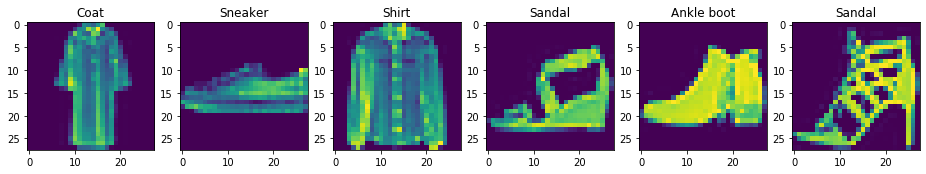

In [1]:
from typing import Tuple
import random
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy as np

# For reproducibility
np.random.seed(500)

# https://github.com/zalandoresearch/fashion-mnist
dataset = sklearn.datasets.fetch_openml(name='Fashion-MNIST')
X = dataset['data']
y = dataset['target'].astype(int)
D = X.shape[-1]
m = int(np.sqrt(D))


labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle boot'
}


def display_examples(X: np.ndarray, y: np.ndarray, n_images: int = 6) -> None:
    fig, axs = plt.subplots(1, n_images, figsize=(16, 5))
    idxs = random.sample(range(len(X)), n_images)

    for i, idx in enumerate(idxs):
        axs[i].imshow(X[idx, ...].reshape(m, m))
        axs[i].set_title(labels[y[idx]])

display_examples(X, y)

### Introducing the problem

We define each of the images as a flattened vector $\pmb{x} \in \mathcal{R}^{D = m \times m}$ where each pixel is represented as a Bernoulli variable $x_i$ conditioned by parameter $\mu_i$:

$$
x_i \sim Bernoulli(\mu_i) \\
P(x_i | \mu_i) = \mu_i^{x_i} (1 - \mu_i)^{(1 - x_i)}
$$

Each example is conformed by a set of $D$ binary variables. The likelihood of $\pmb{x}$ is defined as:

$$
P(\pmb{x} | \pmb{\mu}) = \prod^{D}_{i=1} P(x_i | \mu_i) = \prod^{D}_{i=1} \mu_i^{x_i} (1 - \mu_i)^{(1 - x_i)}
$$

Where $\pmb{\mu} = \{ \mu_1, \ldots, \mu_D\}^{\top}$.

We define a mixture of $K$ components, as we know there are $K=10$ generating distributions, one for each type of clothing:

$$
P(\pmb{x} | \pmb{\mu}, \pmb{\pi}) = \sum^{K}_{k=1} \pi_k P(\pmb{x} | \pmb{\mu_k})
$$

Where $\pmb{\mu} = \{\pmb{\mu_1}, \ldots, \pmb{\mu_K}\}$ and $\pmb{\pi} = \{\pi_1, \ldots, \pi_K\}$.

The log likelihood of the model, which we would like to maximize, is defined as:

$$
\log P(\pmb{X} | \pmb{\mu}, \pmb{\pi}) = \sum^N_{i=1} \log \left\{ \sum^K_{k=1} \pi_k P(\pmb{x_i} | \pmb{\mu_k}) \right\}
$$

This does not have a closed solution.

## Introducing Latent Variables

Let's maximize the log likelihood for the mixture model through EM. Let's add a latent variable $\pmb{z} = \{z_1, \ldots, z_K\}$ associated with each of the examples as a binary vector where one and only one of the $K$ elements in the vector is equal to one.

The conditional distribution of $\pmb{x}$ given $\pmb{z}$ is given by:

$$
P(\pmb{x} | \pmb{z}, \pmb{\mu}) = \prod^K_{k=1} P(\pmb{x} | \mu_k)^{z_k}
$$

And the prior probability for $\pmb{z}$ is given by:

$$
P(\pmb{z} | \pmb{\pi}) = \prod^{K}_{k=1} \pi_k^{z_k}
$$

Given set of $\pmb{N}$ instances and corresponding latent variables $\pmb{Z}$, we can graphically represent the model:

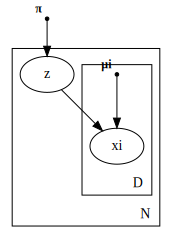

In [2]:
from graphviz import Digraph

plate_nb = Digraph()

plate_nb.node('p', xlabel='<<b><font point-size="12">&pi;</font></b>>', shape='point')

with plate_nb.subgraph(name='cluster_n') as plate_n:
    
    with plate_n.subgraph(name='cluster_d') as plate_d:
        
        plate_d.node('m', xlabel='<<b><font point-size="12">&mu;i</font></b>>', shape='point')
        plate_d.node('x', 'xi')
        plate_d.edge('m', 'x')
        plate_d.attr(label='D', labeljust='r', labelloc='b')

    plate_n.node('z')
    plate_n.edge('z', 'x')
    plate_n.attr(label='N', labeljust='r', labelloc='b')

plate_nb.edge('p', 'z')
    
plate_nb

The joint probability can be expressed as:
    
$$
P(\pmb{X}, \pmb{Z} | \pmb{\theta}) = P(\pmb{X} | \pmb{Z}, \pmb{\mu}) P(\pmb{Z} | \pmb{\pi})
$$

Where $\pmb{\theta}$ is the list of parameters of the model.


The complete likelihood of the model can be expressed as:

$$
\begin{align*}
P(\pmb{X}, \pmb{Z} | \pmb{\theta}) & = \prod_{i=1}^N \prod_{k=1}^{K} P(\pmb{x_i} | \pmb{\mu_k})^{z_{ik}} \prod_{s=1}^{K} \pi_k^{z_{is}} \\
                                   & = \prod_{i=1}^N \prod_{k=1}^{K} \left(\pi_k P(\pmb{x_i} | \pmb{\mu_k})\right)^{z_{ik}}
\end{align*}
$$

Our goal is to obtain $\pmb{\theta}^{*}$ so the log likelihood of the data is maximal:

$$
\begin{align*}
\pmb{\theta}^{*} & = \underset{\pmb{\theta}}{\mathrm{argmax}} \log P(\pmb{X}, \pmb{Z} | \pmb{\theta}) \\
                 & = \sum_{i=1}^{N} \sum_{k=1}^{K} \log \left\{ \left( \pi_k P(\pmb{x_i} | \pmb{\mu_k}) \right)^{z_{ik}} \right\} \\
                 & = \sum_{i=1}^{N} \sum_{k=1}^{K} z_{ik} \log \pi_k P(\pmb{x_i} | \pmb{\mu_k}) \\
                 & = \sum_{i=1}^{N} \sum_{k=1}^{K} z_{ik} \left[ \log \pi_k + \log P(\pmb{x_i} | \pmb{\mu_k}) \right] \\
                 & = \sum_{i=1}^{N} \sum_{k=1}^{K} z_{ik} \left[ \log \pi_k + \sum^{D}_{j=1} x_{ij} \log \mu_{kj} + (1 - x_{ij}) \log (1 - \mu_{kj}) \right] \\              
\end{align*}
$$

### E-step

In this step, [as seen previously](3_0_generic_em_algorithm.ipynb), we set the lower bound function at iteration $t$ to the posterior of the latent variables:

$$
q^{t+1} (\pmb{Z}) = P(\pmb{Z}|\pmb{X}, \pmb{\theta}^t)
$$

The posterior can be obtained through the Bayes theorem:

$$
P(z_{ik} = 1 | \pmb{x_i}) = \frac{P(\pmb{x_i} | z_{ik} = 1)P(z_{ik}=1)}{P(\pmb{x_i})}
$$

The conditional probability of $x$ given the latent variable $z$ is defined as:

$$
P(\pmb{x_i} | z_k = 1, \pmb{\mu}) = P(x | \mu_k)
$$

And the prior probability of $\pmb{z}$ is:

$$
P(z_{ik}=1) = \pi_k
$$

Finally, the normalization term can be obtained through marginalization from the joint probability distribution of $x$ and $z$:

$$
P(\pmb{x}, \pmb{z}) = P(\pmb{x}| \pmb{\mu}, \pmb{z})P(\pmb{z})
$$

So:

$$
P(\pmb{x}) = \sum_k^K P(\pmb{x}|z_k = 1)P(z_k=1)
$$

Therefore, responsability $z_ik$ is computed as:

$$
\begin{align*}
P(z_{ik} | \pmb{x_i}) & = \frac{P(\pmb{x_i} | z_{ik} = 1)P(z_{ik}=1)}{P(\pmb{x})} \\
              & = \frac{P(z_{ik} = 1) P(x_i | \mu_k)}{\sum_j^K P(\pmb{x_i}|z_{ij} = 1)P(z_{ij}=1)} \\
              & = \frac{\pi_k P(\pmb{x_i}| \pmb{\mu_k})}{\sum_j^K \pi_j P(\pmb{x_i}| \pmb{\mu_j})}
\end{align*}
$$

### M-Step

In the M-Step, we maximize the log likelihood of the data with respect to $\pmb{\theta}$. Let's find, first, the derivative of the log likelihood with respect to $\mu_k$ (i.e. probability of passing for grader $k$) using the posterior probability computed in the previous step:

$$
\begin{align*}
\frac{\partial}{\partial{\pmb{\mu_k}}} \log P(\pmb{X}, \pmb{Z} | \pmb{\theta}) & = \frac{\partial}{\partial{\pmb{\mu_k}}} \left\{ \sum_{i=1}^{N} \sum_{j=1}^{K} q^{t+1}(z_{ij} | \pmb{x_i}) \left[ \log \pi_j + \sum^{D}_{d=1} x_{id} \log \mu_{jd} + (1 - x_{id}) \log (1 - \mu_{jd}) \right] \right\} \\
                                                                               & = \sum_{i=1}^{N} q^{t+1}(z_{ik} | \pmb{x_i}) \frac{\partial}{\partial{\pmb{\mu_k}}} \left\{ \sum^{D}_{d=1} x_{id} \log \mu_{kd} + (1 - x_{id}) \log (1 - \mu_{kd}) \right\} \\
\end{align*}
$$


Let's find the derivative with respect to $\mu_{kj}$ instead:

$$
\begin{align*}
\frac{\partial}{\partial{\mu_{kj}}} \log P(\pmb{X}, \pmb{Z} | \pmb{\theta}) & = \sum_{i=1}^{N} q^{t+1}(z_{ik} | \pmb{x_i}) \frac{\partial}{\partial{\mu_{kj}}} \left\{ \sum^{D}_{d=1} x_{id} \log \mu_{kd} + (1 - x_{id}) \log (1 - \mu_{kd}) \right\} \\
                                                                            & = \sum_{i=1}^{N} q^{t+1}(z_{ik} | \pmb{x_i}) \frac{\partial}{\partial{\mu_{kj}}} \left( x_{ij} \log \mu_{kj} + (1 - x_{ij}) \log (1 - \mu_{kj}) \right) \\
                                                                            & = \sum_{i=1}^{N} q^{t+1}(z_{ik} | \pmb{x_i}) \left( \frac{x_{ij}}{\mu_{kj}} -  \frac{1 - x_{ij}}{1 - \mu_{kj}} \right) \\                      
                                                                            & = \sum_{i=1}^{N}q^{t+1}(z_{ik} | \pmb{x_i})  \frac{x_{ij}}{\mu_{kj}} - \sum_{i=1}^{N} q^{t+1}(z_{ik} | \pmb{x_i}) \frac{(1 - x_{ij})}{(1 - \mu_{kj})} \\                        
                                                                            & = \frac{1}{\mu_{kj}} \sum_{i=1}^{N}q^{t+1}(z_{ik} | \pmb{x_i}) x_{ij} - \frac{1}{(1 - \mu_{kj})} \sum_{i=1}^{N} q^{t+1}(z_{ik} | \pmb{x_i}) + \frac{1}{(1 - \mu_{kj})} \sum_{i=1}^{N} q^{t+1}(z_{ik}| \pmb{x_i}) x_{ij} \\
                                                                            & = \left(\frac{1}{\mu_{kj}} + \frac{1}{1 - \mu_{kj}} \right) \sum_{i=1}^{N}q^{t+1}(z_{ik}| \pmb{x_i}) x_{ij} - \frac{1}{(1 - \mu_k)} \sum_{i=1}^{N} q^{t+1}(z_{ik} | \pmb{x_i}) \\
                                                                            & = \frac{1}{\mu_{kj} (1 - \mu_{kj})}  \sum_{i=1}^{N}q^{t+1}(z_{ik} | \pmb{x_i}) x_{ij} - \frac{1}{(1 - \mu_{kj})} \sum_{i=1}^{N} q^{t+1}(z_{ik} | \pmb{x_i}) \\
\end{align*}
$$

If we set the derivative to zero:

$$
\begin{align*}
\frac{1}{\mu_{kj} (1 - \mu_{kj})}  \sum_{i=1}^{N}q^{t+1}(z_{ik} | \pmb{x_i}) x_i - \frac{1}{(1 - \mu_{kj})} \sum_{i=1}^{N} q^{t+1}(z_{ik}  | \pmb{x_i}) & = 0 \\
\frac{1}{\mu_{kj}}  \sum_{i=1}^{N}q^{t+1}(z_{ik} | \pmb{x_i}) x_{ij} & = \sum_{i=1}^{N} q^{t+1}(z_{ik} | \pmb{x_i}) \implies \mu_{kj} = \frac{\sum_{i=1}^{N}q^{t+1}(z_{ik} | \pmb{x_i}) x_{ij}}{\sum_{i=1}^{N} q^{t+1}(z_{ik} | \pmb{x_i})} \\
\end{align*}
$$

The former is equivalent, in the vector form, to (as seen in [here](http://fourier.eng.hmc.edu/e176/lectures/ch9/node19.html)):

$$
\mu_{k} = \frac{\sum_{i=1}^{N}q^{t+1}(z_{ik} = 1 | x_i) \pmb{x_i}}{\sum_{i=1}^{N} q^{t+1}(z_{ik} = 1 | x_i)} \\
$$

The derivation of $\pi_k$ is analogous to the one already shown for [Gaussian Mixture models](2_2_gmm_em_algorithm.ipynb), so there is not need to derive it:

$$
\pi_k = \frac{1}{N} \sum_{i=1}^N q^{t+1}(z_{ik} = 1 | \pmb{x_i})
$$

As it is usually referred in the literature, we can write $N_k$ as:

$$
N_k = \sum_{i=1}^N q^{t+1}(z_{ik} = 1 | \pmb{x_i})
$$

Then, we finally present the update formulas for $\pmb{\mu_k}$, $\pi_k$ at step $t+1$:

$$
\pmb{\mu_k}^{t+1} = \frac{1}{N_k} \sum_{i=1}^{N}q^{t+1}(z_{ik} = 1 | \pmb{x_i}) \pmb{x_i} \\
\pi_k^{t+1} = \frac{N_k}{N}
$$

## Data processing

We need to convert grayscale data into binary. To do so, for each pixel $p$, we apply the following function $f$:

$$
f(p) = 
\begin{cases}
1 & p \ge 5 \\
0 & otherwise
\end{cases}
$$

In [3]:
def binarize(pixel: np.ndarray) -> bool:
    if pixel > 5:
        return 1
    else:
        return 0

binarize_fn = np.vectorize(binarize)
X = binarize_fn(X)

Let's visualize the binarized result.

Then, we select a subset of the data for our problem. Let's narrow the scope of the problem to 3 different types of clothing: Bag (8), T-Shirt (0), Sneaker (7).

In [4]:
n = 15000
n_clusters = 5
subset_idxs = list(np.where((y == 0) | (y == 7) | (y == 8))[0])
idxs = random.sample(subset_idxs, n)

X = X[idxs, ...]
y = y[idxs, ...]

Let's see some binarized examples.

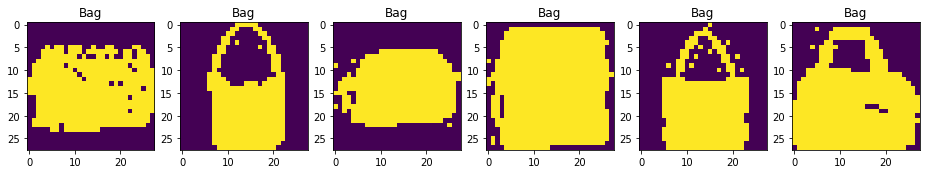

In [5]:
display_examples(X, y)

Note that further work could be done by applying morphological applications. However, leave that as future work.

## Implementation

Let's first implement the E-Step.

We observe that the product of the $D$ random variables in $P(\pmb{x}|\pmb{\mu})$ may lead to handling very small numbers, which lead to underflow. Instead, we will be using the exponential of the logarithm:

$$
\begin{align*}
exp \log P(z_kj = 1 | \pmb{x_i}) & = \exp \log \frac{\pi_k P(\pmb{x_i}| \pmb{\mu_k})}{\sum_j^K \pi_j P(\pmb{x_i}| \pmb{\mu_k})} \\
                                 & = \exp \left\{ \log \pi_k + \log \prod^{D}_{j=1} \mu_{kj}^{x_{ij}} (1 - \mu_{kj})^{(1 - x_{ij})} - \log \sum_j^K \pi_j P(\pmb{x_i}| \pmb{\mu_k}) \right\} \\
                                 & = \exp \left\{ \log \pi_k + \sum^{D}_{j=1} \left[ x_{ij} \log \mu_{kj} + (1 - x_{ij}) \log (1 - \mu_{kj}) \right] - \log \sum_j^K \pi_j P(\pmb{x_i}| \pmb{\mu_k}) \right\}
\end{align*}
$$

The numerator is straightforward to compute but the denominator still may underflow.

Note the denominator will be used as the sum over each $\pmb{\mu_i}$ for each row $\pmb{x}$. So we can apply again the exp-log trick within the summation:

$$
\begin{align*}
\log \sum_j^K \pi_j P(\pmb{x_i}| \pmb{\mu_k}) & = \log \sum_j^K \exp \log \pi_j P(\pmb{x_i}| \pmb{\mu_k}) \\
                                              & = \log \sum_j^K \exp \left\{ \log \pi_k + \sum^{D}_{j=1} \left[ x_{ij} \log \mu_{kj} + (1 - x_{ij}) \log (1 - \mu_{kj}) \right] \right\}
\end{align*}
$$

There are built-in functions for computing the log of the sum over exp (see [this](https://numpy.org/doc/stable/reference/generated/numpy.logaddexp.html)) in a stable way.

In [6]:
def e_step(X: np.ndarray,
           mus: np.ndarray,
           coefs: np.ndarray) -> np.ndarray:
    
    log_weighted_p_x_mu = \
        np.log(coefs) + \
        np.dot(X, np.log(mus).T) + \
        np.dot(1 - X, np.log(1 - mus).T)
    
    log_normalization = np.logaddexp.reduce(log_weighted_p_x_mu,
                                            axis=1)[:, None]
    
    return np.exp(log_weighted_p_x_mu - log_normalization)

Now let's implement the updates for the M-Step.

In [7]:
from typing import Tuple

def m_step(X: np.ndarray,
           responsibilities: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    n_k = responsibilities.sum(axis=0)
    # Compute center vectors
    mus = np.dot(responsibilities.T, X) / n_k[:, None]
    # Compute mixing coefficients
    coefs = n_k / len(X)
    return mus, coefs

Implement log likelihood.

In [8]:
def log_likelihood(X: np.ndarray,
                   mus: np.ndarray,
                   coefs: np.ndarray) -> float:
    log_weighted_p_x_mu = \
        np.log(coefs) + \
        np.dot(X, np.log(mus).T) + \
        np.dot(1 - X, np.log(1 - mus).T)
    
    return log_weighted_p_x_mu.sum()

Initialize optimization process.

In [9]:
from mixture import sample_coefs

def normalize_mus(mus: np.ndarray) -> np.ndarray:
    new_mus = mus.copy()
    n_clusters = mus.shape[0]
    sum_over_clusters = mus.sum(axis=1)
    
    for k in range(n_clusters):
        new_mus[k, ...] = mus[k, ...] / sum_over_clusters[k]
    
    return new_mus

# As in Bishop's Book
init_mus = normalize_mus(
    np.random.uniform(low=0.25, high=0.75, size=(n_clusters, D))
)
init_coefs = 1/n_clusters * np.ones(n_clusters)

Compute initial likelihood.

In [10]:
init_likelihood = log_likelihood(X, init_mus, init_coefs)
print(f'Initial likelihood: {init_likelihood}')

Initial likelihood: -188161568.05984232


Let's perform training.

In [11]:
mus = init_mus
coefs = init_coefs

init_likelihood = log_likelihood(X, mus, coefs)
print(f'Initial likelihood: {init_likelihood}')

iter_mus = [init_mus]
n_iterations = 5

for iteration in range(n_iterations):
    
    # E-step
    responsibilities = e_step(X, mus, coefs)

    # M-step
    mus, coefs = m_step(X, responsibilities)

    # Add constant to avoid mus of 0 and
    # It may lead to likelihood decreases at some iterations
    mus = mus + 1e-30
    
    # Evaluation step
    likelihood = log_likelihood(X=X, mus=mus, coefs=coefs)
    
    print(f'[{iteration}] Log likelihood: {likelihood:.2f}')
    
    # Store mus at iteration
    iter_mus.append(mus)

Initial likelihood: -188161568.05984232
[0] Log likelihood: -36504461.89
[1] Log likelihood: -77969439.92
[2] Log likelihood: -105323061.04
[3] Log likelihood: -112627456.54
[4] Log likelihood: -115463471.09


### Create animation with iteration results

In [12]:
import gif
import os
from typing import Optional

@gif.frame
def display_images(images: np.ndarray, title: Optional[str]) -> None:
    n_images = len(images)
    fig, axs = plt.subplots(1, n_images, figsize=(16, 5))
    for k in range(n_images):
        axs[k].imshow(images[k].reshape(m, m))
        axs[k].set_title(f'Cluster {k}')
    
    if title is not None:
        fig.suptitle(title)


frames = []
for i in range(len(iter_mus)):
    title = 'Initial probabilities' if i == 0 else f'Iteration {i}'
    frames.append(display_images(iter_mus[i], title))

animation_path = os.path.join('media', 'bernoulli_mixture_em.gif')

if not os.path.isfile(animation_path):
    gif.save(frames, animation_path, duration=500)

![SegmentLocal](media/bernoulli_mixture_em.gif )

### Create animation with samples

In [13]:
from scipy.stats import bernoulli

def sample(mus: np.ndarray) -> np.ndarray:
    return np.array([bernoulli(p=i).rvs() for i in mus]).reshape(m, m)

frames = []
for _ in range(50):
    samples = [sample(mus[k]) for k in range(n_clusters)]
    frames.append(display_images(samples, 'Sampled binary examples'))

animation_path = os.path.join('media', 'bernoulli_mixture_em_examples.gif')

if not os.path.isfile(animation_path):
    gif.save(frames, animation_path, duration=500)

![SegmentLocal](media/bernoulli_mixture_em_examples.gif )

### Links/Credits

- [Chapter 9 from Bishop's book](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf).
- [Mixture models lecture from Buffalo University](https://cedar.buffalo.edu/~srihari/CSE574/Chap9/Ch9.4-MixturesofBernoulli.pdf).
- [Notes on Bernoulli Mixtures from  Harvey Mudd College](http://fourier.eng.hmc.edu/e176/lectures/ch9/node19.html).
- [Using the "log-sum-exp trick" post from Stack Exchange](https://stats.stackexchange.com/questions/105602/example-of-how-the-log-sum-exp-trick-works-in-naive-bayes).

Used code from this [Kaggle kernel](https://www.kaggle.com/allunia/uncover-target-correlations-with-bernoulli-mixture/notebook) as sanity check.

### Future work

- [ ] Use GMM for any distribution in a generic way
- [ ] Apply morphological operations for better binarization